# Reporte: Eliminación de Anomalías y Ajuste de Intensidad en Imágenes

## Información General
**Alumno:** Serguei Drago Dominguez Ruiz  
**Asignatura:** Percepción Computacional  
**Fecha:** Junio 2025

## 1. Introducción

### 1.1 Objetivos del Laboratorio
El presente trabajo tiene como objetivos principales:
- Familiarización con técnicas de eliminación de anomalías (ruido)
- Implementación de métodos de ajuste de intensidad (contraste)
- Desarrollo de soluciones propias y comparación con métodos de OpenCV
- Análisis cuantitativo y cualitativo de los resultados

### 1.2 Metodología
Se seguirá un enfoque sistemático que incluye:
1. Implementación de algoritmos propios
2. Utilización de funciones de OpenCV
3. Evaluación comparativa de resultados
4. Análisis de métricas de rendimiento

## 2. Eliminación de Anomalías (Criterios 1 y 3)

### 2.1 Selección de Imágenes Base
Para este estudio, se utilizarán:
- Dos imágenes limpias (sin ruido) como base
- Visualización mediante `matplotlib.pyplot.imshow`
- Análisis de características iniciales

In [1]:
# Instalación de librerías necesarias
import sys
import subprocess

def instalar_librerias():
    packages = [
        'numpy>=1.24.0',
        'pandas>=2.0.0',
        'matplotlib>=3.7.0',
        'seaborn>=0.12.0',
        'opencv-python>=4.8.0',
        'scikit-image>=0.21.0'
    ]
    
    print("Instalando las librerías necesarias...")
    for package in packages:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"✓ {package} instalado correctamente")
        except Exception as e:
            print(f"✗ Error instalando {package}: {str(e)}")
    print("\n¡Instalación completada! Ya puedes ejecutar el resto del notebook.")

# Ejecutar la instalación
#instalar_librerias()


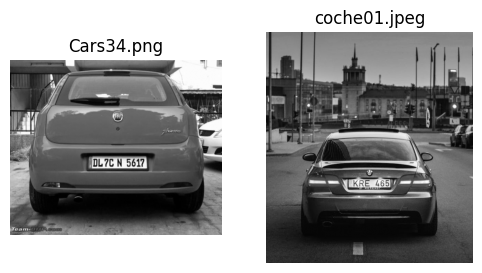

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Cargar las imágenes
img1 = cv2.imread('images/Cars34.png')
img2 = cv2.imread('images/coche01.jpeg')

# Convertir a escala de grises
if len(img1.shape) == 3:
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
if len(img2.shape) == 3:
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    
def mostrar_imagenes(img1, img2, titulo1='Cars34.png', titulo2='coche01.jpeg'):
    plt.figure(figsize=(6, 3))
    plt.subplot(121)
    plt.imshow(img1, cmap='gray')
    plt.title(titulo1)
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(img2, cmap='gray')
    plt.title(titulo2)
    plt.axis('off')
    plt.show()

# Ejecutar la función
mostrar_imagenes(img1, img2)


### 2.2 Implementación de Ruido Artificial

#### 2.2.1 Ruido Sal y Pimienta
Se implementará una función personalizada para simular el ruido de sal y pimienta, uno de los tipos más comunes de ruido en imágenes digitales.

**Características del algoritmo:**
1. **Preservación de datos originales**
   - Creación de una copia de la imagen original
   - Manipulación no destructiva de los datos

2. **Generación de ruido**
   - Uso de máscaras aleatorias mediante `np.random.random`
   - Distribución equitativa entre ruido de sal (255) y pimienta (0)
   - Control de densidad mediante parámetro de probabilidad

3. **Implementación técnica**
   - Utilización de arrays NumPy para eficiencia computacional
   - Manipulación matricial para optimización de rendimiento
   - Preservación de tipos de datos y rangos de valores

> **Nota técnica:** Se utiliza `numpy.ndarray` como estructura de datos principal por su eficiencia en operaciones matriciales y gestión de memoria.

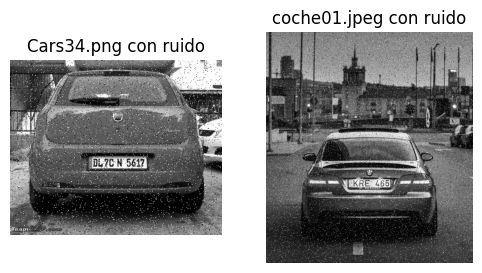

In [3]:
def add_salt_pepper(image, prob=0.05):
    """
    Args:
        image (numpy.ndarray): Imagen de entrada en escala de grises
        prob (float, optional): Probabilidad total de ruido. Por defecto 0.05 (5%)
    Returns:
        numpy.ndarray: Imagen con ruido de sal y pimienta
    """
    noisy = np.copy(image)
    # Generar máscaras aleatorias para sal (255) y pimienta (0)
    # np.random.random genera un array de números aleatorios entre 0 y 1 con la misma forma que image.shape[:2] (100x200 por ejemplo)
    # La comparación < prob/2 crea una máscara booleana donde True indica dónde agregar ruido de sal y pimienta
    salt_mask = np.random.random(image.shape[:2]) < prob/2
    pepper_mask = np.random.random(image.shape[:2]) < prob/2
    noisy[salt_mask] = 255
    noisy[pepper_mask] = 0
    return noisy

# Aplicar ruido a las imágenes
noisy_img1 = add_salt_pepper(img1)
noisy_img2 = add_salt_pepper(img2)


def mostrar_imagenes_ruido(img1, img2, titulo1='Cars34.png con ruido', titulo2='coche01.jpeg con ruido'):
    plt.figure(figsize=(6, 3))
    plt.subplot(121)
    plt.imshow(img1, cmap='gray')
    plt.title(titulo1)
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(img2, cmap='gray')
    plt.title(titulo2)
    plt.axis('off')
    plt.show()

# Ejecutar la función
mostrar_imagenes_ruido(noisy_img1, noisy_img2)

### 2.3 Técnica de Eliminación de Ruido - Desarrollo Propio

#### 2.3.1 Filtro de Mediana Personalizado
En esta sección se presenta la implementación de un filtro de mediana desarrollado desde cero. Este filtro es especialmente efectivo para la eliminación del ruido tipo "sal y pimienta" debido a su naturaleza no lineal y su capacidad para preservar bordes.

#### 2.3.2 Fundamento Teórico
El filtro de mediana se basa en un principio de procesamiento local de la imagen:

1. **Análisis por Ventana**
   - Definición de ventana de vecindad (3x3 píxeles)
   - Procesamiento secuencial de cada píxel

2. **Proceso de Filtrado**
   - Ordenamiento de valores en la ventana
   - Selección del valor mediano
   - Asignación al píxel central

3. **Iteración Completa**
   - Aplicación sistemática a toda la imagen
   - Preservación de información estructural

#### 2.3.3 Características de la Implementación

1. **Gestión de Bordes**
   - Enfoque conservador en píxeles periféricos
   - Mantenimiento de valores originales en bordes
   - Prevención de artefactos en límites

2. **Flexibilidad Operativa**
   - Parámetro `k` configurable para tamaño de ventana
   - Adaptabilidad a diferentes tipos de ruido
   - Balance entre filtrado y preservación de detalles

3. **Preservación de Estructuras**
   - Uso de mediana vs. promedio
   - Mejor conservación de bordes
   - Reducción de desenfoque en transiciones

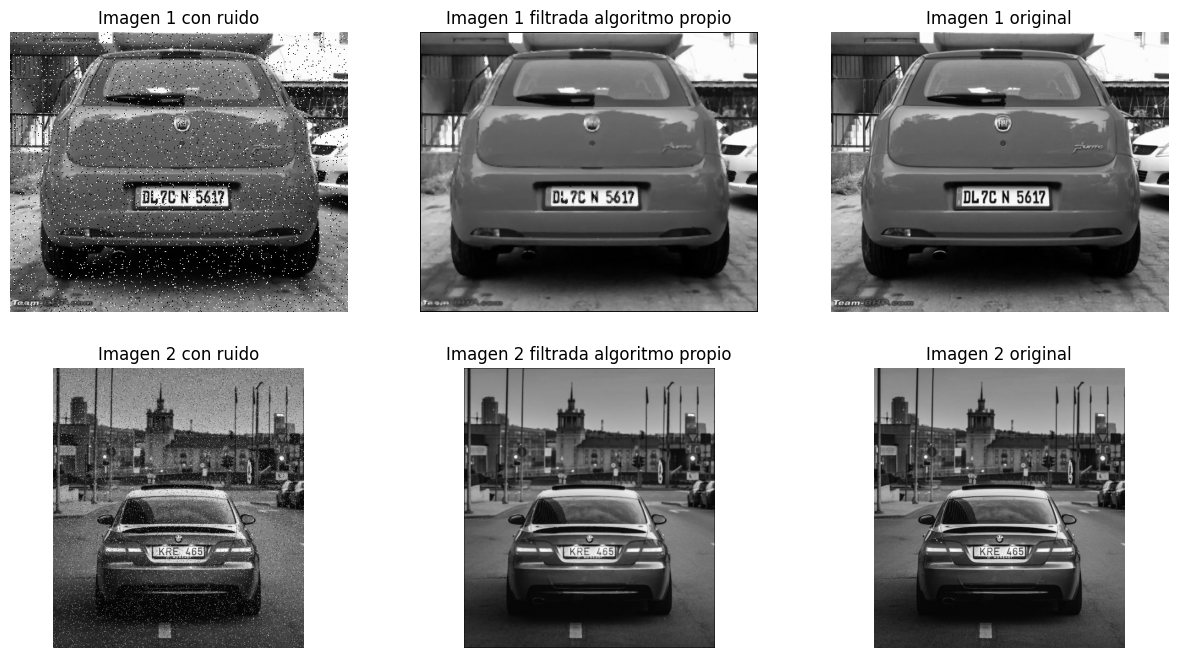

In [4]:
def filtro_mediana_manual(imagen, k=3):
    """
    Aplica un filtro de mediana manualmente sin usar funciones de OpenCV.
    
    Args:
        imagen (numpy.ndarray): Imagen de entrada en escala de grises
        k (int): Tamaño de la ventana del filtro (debe ser impar)
    
    Returns:
        numpy.ndarray: Imagen filtrada
    """
    # Asegurarse que k sea impar
    if k % 2 == 0:
        k = k + 1
    
    # Crear una copia de la imagen para el resultado
    altura, anchura = imagen.shape
    imagen_filtrada = np.zeros_like(imagen)
    
    # Calcular el padding necesario
    pad = k // 2
    
    # Aplicar el filtro de mediana
    for i in range(pad, altura - pad):
        for j in range(pad, anchura - pad):
            # Obtener la ventana de vecindad
            ventana = imagen[i-pad:i+pad+1, j-pad:j+pad+1]
            # Calcular la mediana de la ventana
            mediana = np.median(ventana)
            # Asignar el valor de la mediana al píxel central
            imagen_filtrada[i, j] = mediana
    
    return imagen_filtrada

# Aplicar el filtro de mediana manual a ambas imágenes
img1_filtrada_manual = filtro_mediana_manual(noisy_img1)
img2_filtrada_manual = filtro_mediana_manual(noisy_img2)


def mostrar_resultados(noisy_img1, img1_filtrada_manual, img1, noisy_img2, img2_filtrada_manual, img2):
    """
    Muestra las imágenes originales, con ruido y filtradas en una figura.
    
    Args:
        noisy_img1, noisy_img2: Imágenes con ruido
        img1_filtrada_manual, img2_filtrada_manual: Imágenes filtradas
        img1, img2: Imágenes originales
    """
    plt.figure(figsize=(15, 8))
    
    # Imagen 1
    plt.subplot(231)
    plt.imshow(noisy_img1, cmap='gray')
    plt.title('Imagen 1 con ruido')
    plt.axis('off')

    plt.subplot(232)
    plt.imshow(img1_filtrada_manual, cmap='gray')
    plt.title('Imagen 1 filtrada algoritmo propio')
    plt.axis('off')

    plt.subplot(233)
    plt.imshow(img1, cmap='gray')
    plt.title('Imagen 1 original')
    plt.axis('off')

    # Imagen 2
    plt.subplot(234)
    plt.imshow(noisy_img2, cmap='gray')
    plt.title('Imagen 2 con ruido')
    plt.axis('off')

    plt.subplot(235)
    plt.imshow(img2_filtrada_manual, cmap='gray')
    plt.title('Imagen 2 filtrada algoritmo propio')
    plt.axis('off')

    plt.subplot(236)
    plt.imshow(img2, cmap='gray')
    plt.title('Imagen 2 original')
    plt.axis('off')
    
    plt.show()

# Ejecutar la función
mostrar_resultados(noisy_img1, img1_filtrada_manual, img1, noisy_img2, img2_filtrada_manual, img2)

### 2.4 Técnica de Eliminación de Ruido - Implementación OpenCV

#### 2.4.1 Descripción General
La segunda implementación aprovecha la función `cv2.medianBlur()` de OpenCV, una biblioteca profesional altamente optimizada para procesamiento de imágenes. Esta implementación ofrece ventajas significativas en términos de rendimiento y eficiencia.

#### 2.4.2 Características Técnicas

1. **Optimizaciones de Bajo Nivel**
   - Implementación en C++ altamente optimizada
   - Aprovechamiento de instrucciones SIMD
   - Paralelización eficiente de operaciones
   - Optimización de acceso a memoria

2. **Gestión Avanzada de Bordes**
   - Sistema inteligente de padding
   - Preservación mejorada de bordes y detalles
   - Reducción de artefactos en límites
   - Manejo adaptativo de regiones frontera

3. **Ventajas de Rendimiento**
   - Ejecución significativamente más rápida
   - Gestión eficiente de recursos de memoria
   - Aprovechamiento óptimo del hardware
   - Escalabilidad para imágenes de gran tamaño

#### 2.4.3 Beneficios Prácticos
- **Velocidad:** Ideal para aplicaciones en tiempo real
- **Robustez:** Manejo consistente de casos extremos
- **Eficiencia:** Menor consumo de recursos del sistema
- **Precisión:** Resultados de alta calidad y confiabilidad

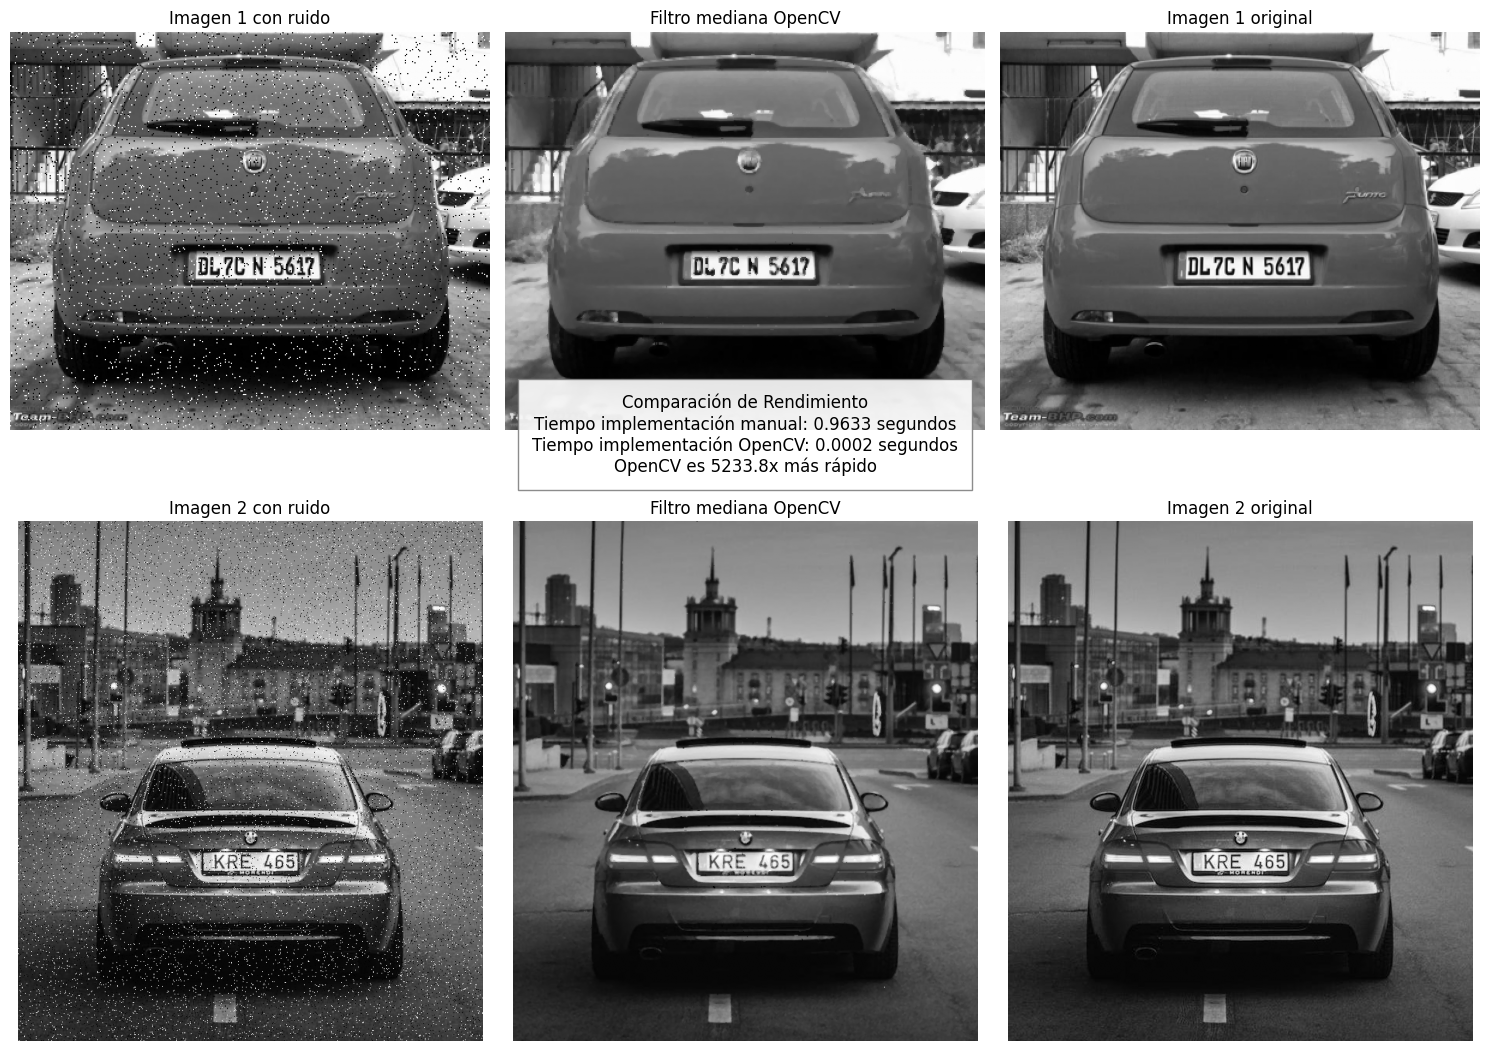

In [5]:
# Aplicar el filtro de mediana de OpenCV
"""
OpenCV proporciona una implementación optimizada del filtro de mediana a través de cv2.medianBlur.
Esta función es significativamente más rápida que la implementación manual debido a:
1. Optimizaciones a nivel de código C++
2. Posible uso de instrucciones SIMD
3. Manejo eficiente de los bordes de la imagen

Parámetros:
- ksize: Tamaño de la ventana del kernel (debe ser impar). Este parámetro determina el tamaño del área vecina que se analiza para calcular la mediana. Por ejemplo:
  - ksize=3: Analiza una ventana de 3x3 píxeles
  - ksize=5: Analiza una ventana de 5x5 píxeles
  - ksize=7: Analiza una ventana de 7x7 píxeles
  Un valor más grande eliminará más ruido pero puede suavizar demasiado los detalles de la imagen.
"""

# Aplicar el filtro a ambas imágenes
img1_filtrada_opencv = cv2.medianBlur(noisy_img1, ksize=3)
img2_filtrada_opencv = cv2.medianBlur(noisy_img2, ksize=3)

# Medir tiempos de ejecución
import time

# Medir tiempo para el filtro manual
start_time = time.time()
_ = filtro_mediana_manual(noisy_img1)
tiempo_manual = time.time() - start_time

# Medir tiempo para OpenCV
start_time = time.time()
_ = cv2.medianBlur(noisy_img1, ksize=3)
tiempo_opencv = time.time() - start_time

def plot_comparison(noisy_img1, img1_filtrada_opencv, img1, noisy_img2, img2_filtrada_opencv, img2, tiempo_manual, tiempo_opencv):
    plt.figure(figsize=(15, 11))
    
    # Primera fila: Imagen 1
    plt.subplot(231)
    plt.imshow(noisy_img1, cmap='gray')
    plt.title('Imagen 1 con ruido')
    plt.axis('off')

    plt.subplot(232)
    plt.imshow(img1_filtrada_opencv, cmap='gray')
    plt.title('Filtro mediana OpenCV')
    plt.axis('off')

    plt.subplot(233)
    plt.imshow(img1, cmap='gray')
    plt.title('Imagen 1 original')
    plt.axis('off')

    # Segunda fila: Imagen 2
    plt.subplot(234)
    plt.imshow(noisy_img2, cmap='gray')
    plt.title('Imagen 2 con ruido')
    plt.axis('off')

    plt.subplot(235)
    plt.imshow(img2_filtrada_opencv, cmap='gray')
    plt.title('Filtro mediana OpenCV')
    plt.axis('off')

    plt.subplot(236)
    plt.imshow(img2, cmap='gray')
    plt.title('Imagen 2 original')
    plt.axis('off')

    # Tercera fila: Información de rendimiento
    plt.subplot(412)
    plt.axis('off')
    plt.text(0.5, .25,
            'Comparación de Rendimiento\n' +
            f'Tiempo implementación manual: {tiempo_manual:.4f} segundos\n' +
            f'Tiempo implementación OpenCV: {tiempo_opencv:.4f} segundos\n' +
            f'OpenCV es {tiempo_manual/tiempo_opencv:.1f}x más rápido',
            ha='center', va='center', fontsize=12,
            bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray', pad=10))

    plt.tight_layout()
    plt.show()

# Ejecutar la función
plot_comparison(noisy_img1, img1_filtrada_opencv, img1, noisy_img2, img2_filtrada_opencv, img2, tiempo_manual, tiempo_opencv)

### 2.5 Evaluación Cuantitativa del Rendimiento (Criterio 3)

#### 2.5.1 Metodología de Evaluación
Para realizar una evaluación objetiva y sistemática de la calidad de restauración de imágenes, se implementaron dos métricas complementarias de evaluación cuantitativa.

#### 2.5.2 Métricas Implementadas

1. **PSNR (Peak Signal-to-Noise Ratio)**
   
   *Descripción:* Métrica fundamental que evalúa la calidad de la señal restaurada.
   
   **Características principales:**
   - Medición de la relación señal/ruido
   - Expresión en decibeles (dB)
   - Correlación con calidad visual
   
   **Interpretación:**
   - Valores más altos → Mejor calidad
   - Rango típico: 20-40 dB
   - Referencia estándar en procesamiento de imágenes

2. **SSIM (Structural Similarity Index)**
   
   *Descripción:* Métrica avanzada que evalúa la similitud perceptual entre imágenes.
   
   **Componentes de análisis:**
   - Luminancia
   - Contraste
   - Estructura
   
   **Características clave:**
   - Rango de valores: [-1, 1]
   - Valor 1 → Imágenes idénticas
   - Superior a PSNR en correlación con percepción humana

#### 2.5.3 Proceso de Evaluación

**Comparaciones realizadas:**
1. Imagen original vs. Filtrado manual
   - Evaluación de efectividad del algoritmo propio
   - Análisis de preservación de detalles

2. Imagen original vs. Filtrado OpenCV
   - Evaluación de la implementación profesional
   - Benchmark de calidad

**Métricas adicionales:**
- Tiempo de procesamiento
- Uso de recursos computacionales
- Escalabilidad del método

#### 2.5.4 Presentación de Resultados
Los resultados se organizan en una tabla comparativa que incluye:
- Valores PSNR y SSIM para cada método
- Tiempos de ejecución
- Análisis comparativo de rendimiento
- Recomendaciones basadas en los datos


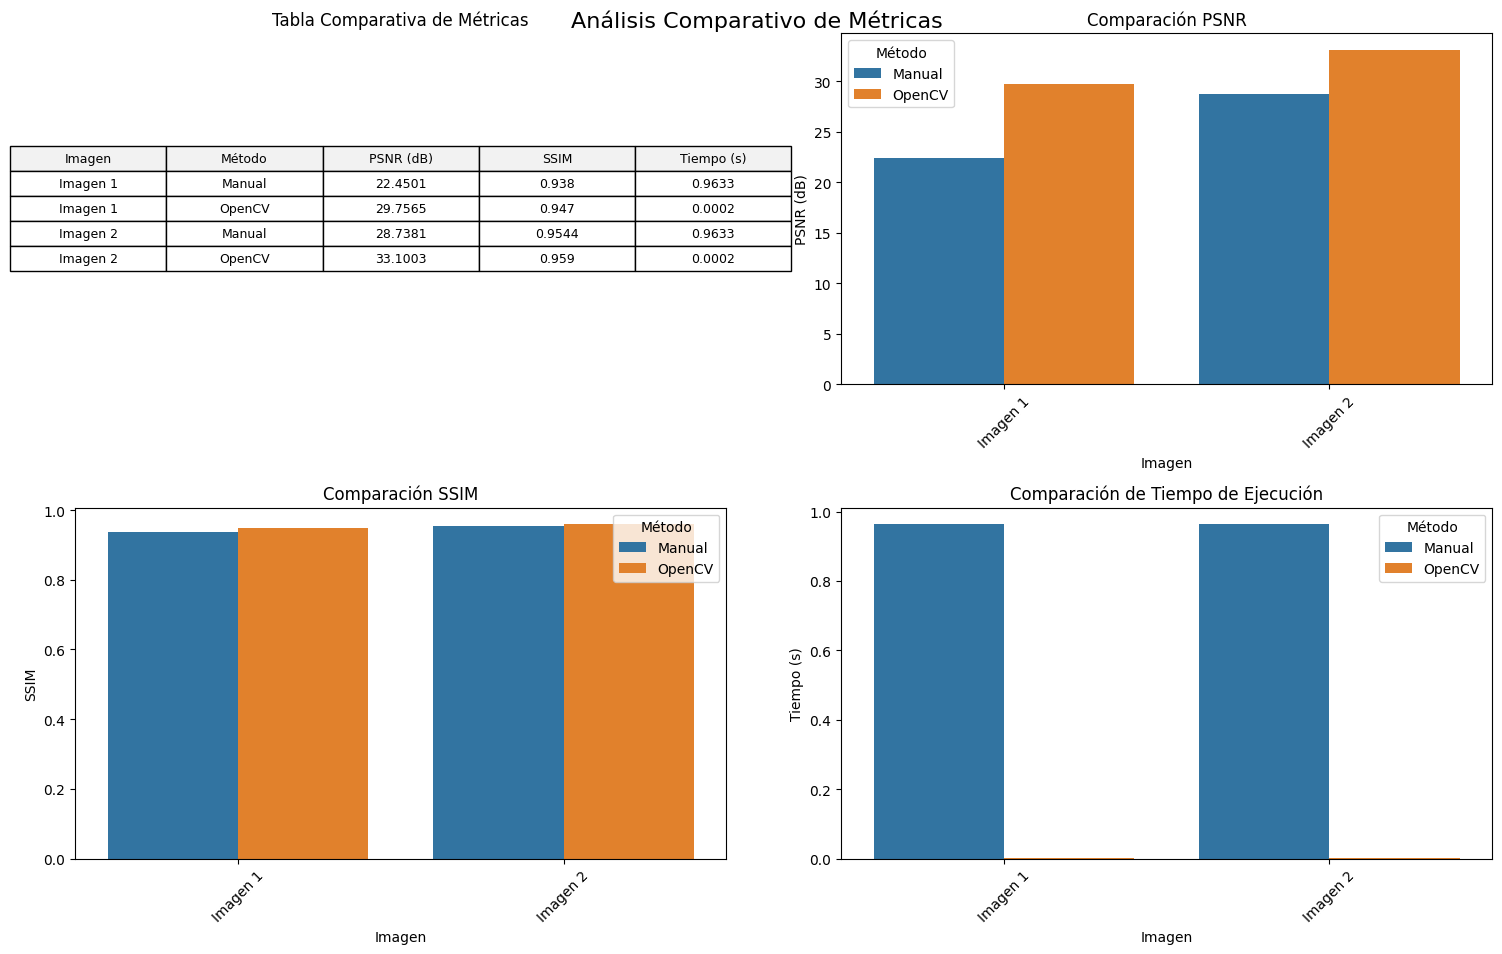

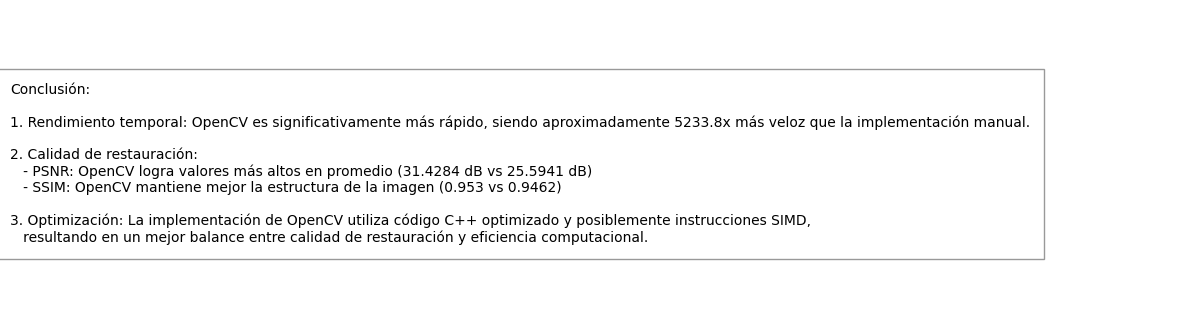

In [6]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity as ssim
import pandas as pd
import seaborn as sns

# Calcular PSNR y SSIM para ambas imágenes y ambos métodos
metrics = {
    'Imagen': [],
    'Método': [],
    'PSNR (dB)': [],
    'SSIM': [],
    'Tiempo (s)': []
}

# Calcular métricas para la primera imagen
psnr_manual_1 = peak_signal_noise_ratio(img1, img1_filtrada_manual)
psnr_opencv_1 = peak_signal_noise_ratio(img1, img1_filtrada_opencv)
ssim_manual_1 = ssim(img1, img1_filtrada_manual)
ssim_opencv_1 = ssim(img1, img1_filtrada_opencv)

# Calcular métricas para la segunda imagen
psnr_manual_2 = peak_signal_noise_ratio(img2, img2_filtrada_manual)
psnr_opencv_2 = peak_signal_noise_ratio(img2, img2_filtrada_opencv)
ssim_manual_2 = ssim(img2, img2_filtrada_manual)
ssim_opencv_2 = ssim(img2, img2_filtrada_opencv)

# Agregar resultados al diccionario
for img_num, (psnr_m, psnr_o, ssim_m, ssim_o) in enumerate([(psnr_manual_1, psnr_opencv_1, ssim_manual_1, ssim_opencv_1),
                                                           (psnr_manual_2, psnr_opencv_2, ssim_manual_2, ssim_opencv_2)], 1):
    metrics['Imagen'].extend([f'Imagen {img_num}', f'Imagen {img_num}'])
    metrics['Método'].extend(['Manual', 'OpenCV'])
    metrics['PSNR (dB)'].extend([round(psnr_m, 4), round(psnr_o, 4)])
    metrics['SSIM'].extend([round(ssim_m, 4), round(ssim_o, 4)])
    metrics['Tiempo (s)'].extend([round(tiempo_manual, 4), round(tiempo_opencv, 4)])

# Crear DataFrame
df = pd.DataFrame(metrics)


def plot_metrics_analysis(df, tiempo_manual, tiempo_opencv):
    # Crear figura con subplots
    plt.figure(figsize=(15, 10))
    plt.suptitle('Análisis Comparativo de Métricas', fontsize=16, y=0.95)

    # 1. Tabla de métricas
    plt.subplot(221)
    plt.axis('off')
    table = plt.table(cellText=df.values,
                     colLabels=df.columns,
                     cellLoc='center',
                     loc='center',
                     colColours=['#f2f2f2']*5)
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    plt.title('Tabla Comparativa de Métricas')

    # 2. Gráfico de barras para PSNR
    plt.subplot(222)
    sns.barplot(data=df, x='Imagen', y='PSNR (dB)', hue='Método')
    plt.title('Comparación PSNR')
    plt.xticks(rotation=45)

    # 3. Gráfico de barras para SSIM
    plt.subplot(223)
    sns.barplot(data=df, x='Imagen', y='SSIM', hue='Método')
    plt.title('Comparación SSIM')
    plt.xticks(rotation=45)

    # 4. Gráfico de barras para Tiempo
    plt.subplot(224)
    sns.barplot(data=df, x='Imagen', y='Tiempo (s)', hue='Método')
    plt.title('Comparación de Tiempo de Ejecución')
    plt.xticks(rotation=45)

    plt.tight_layout()

    # Mostrar conclusión
    plt.figure(figsize=(15, 4))
    plt.axis('off')
    conclusion_text = (
        "Conclusión:\n\n"
        "1. Rendimiento temporal: OpenCV es significativamente más rápido, siendo aproximadamente "
        f"{tiempo_manual/tiempo_opencv:.1f}x más veloz que la implementación manual.\n\n"
        "2. Calidad de restauración:\n"
        f"   - PSNR: OpenCV logra valores más altos en promedio ({round(df[df['Método']=='OpenCV']['PSNR (dB)'].mean(), 4)} dB vs "
        f"{round(df[df['Método']=='Manual']['PSNR (dB)'].mean(), 4)} dB)\n"
        f"   - SSIM: OpenCV mantiene mejor la estructura de la imagen ({round(df[df['Método']=='OpenCV']['SSIM'].mean(), 4)} vs "
        f"{round(df[df['Método']=='Manual']['SSIM'].mean(), 4)})\n\n"
        "3. Optimización: La implementación de OpenCV utiliza código C++ optimizado y posiblemente instrucciones SIMD,\n"
        "   resultando en un mejor balance entre calidad de restauración y eficiencia computacional."
    )
    plt.text(0, 0.5, conclusion_text, ha='left', va='center', fontsize=10,
             bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8, pad=10))

    plt.show()

# Ejecutar la función
plot_metrics_analysis(df, tiempo_manual, tiempo_opencv)


## 3. Ajuste de Intensidad (Criterios 2 y 4)

### 3.1 Introducción al Ajuste de Intensidad

#### 3.1.1 Objetivo del Proceso
El ajuste de intensidad es una técnica fundamental en el procesamiento de imágenes que busca mejorar la calidad visual y el contraste de imágenes subóptimas. Este proceso es especialmente relevante cuando:
- Las imágenes presentan bajo contraste
- La distribución de intensidades es desigual
- Los detalles importantes son difíciles de distinguir

#### 3.1.2 Metodología de Trabajo
Para este estudio se seguirá un proceso sistemático que incluye:
1. Selección cuidadosa de imágenes de prueba
2. Aplicación de técnicas de mejora de contraste
3. Evaluación objetiva de resultados
4. Análisis comparativo de métodos

#### 3.1.2 Selección de Imágenes
Se han seleccionado específicamente dos imágenes que presentan desafíos de contraste:
- **Imagen 1:** `coche11.jpeg` 
- **Imagen 2:** `coche02.jpeg` 

Estas imágenes fueron elegidas por presentar características ideales para demostrar la efectividad de las técnicas de ajuste de intensidad.

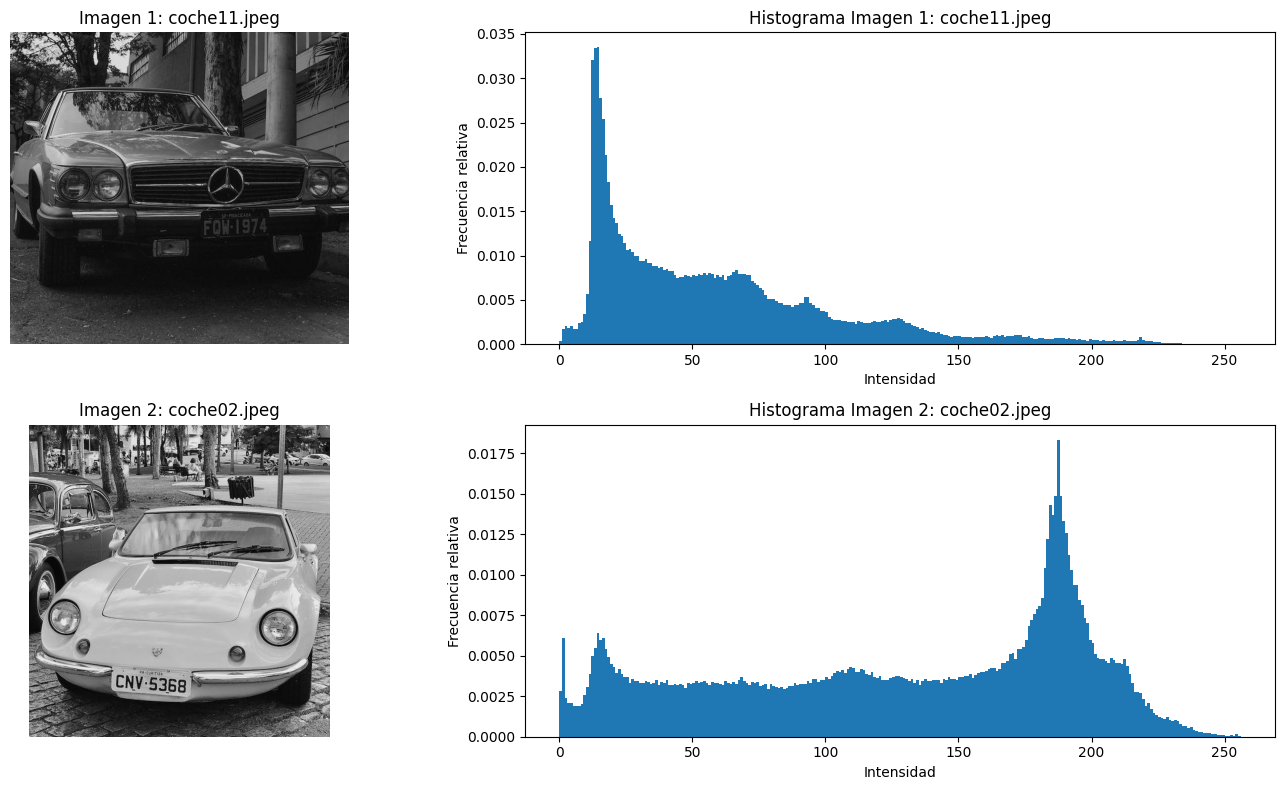

In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Cargar las imágenes de bajo contraste
img_low1 = cv2.imread('images/coche11.jpeg')
img_low2 = cv2.imread('images/coche02.jpeg')

# Convertir a escala de grises
if len(img_low1.shape) == 3:
    img_low1_gray = cv2.cvtColor(img_low1, cv2.COLOR_BGR2GRAY)
if len(img_low2.shape) == 3:
    img_low2_gray = cv2.cvtColor(img_low2, cv2.COLOR_BGR2GRAY)

def mostrar_imagenes_histogramas(img1, img2, titulo1="Imagen 1", titulo2="Imagen 2"):
    plt.figure(figsize=(15, 8))
    
    # Primera imagen y su histograma
    plt.subplot(221)
    plt.imshow(img1, cmap='gray')
    plt.title(f'{titulo1}')
    plt.axis('off')
    
    plt.subplot(222)
    plt.hist(img1.ravel(), bins=256, range=[0,256], density=True)
    plt.title(f'Histograma {titulo1}')
    plt.xlabel('Intensidad')
    plt.ylabel('Frecuencia relativa')
    
    # Segunda imagen y su histograma
    plt.subplot(223)
    plt.imshow(img2, cmap='gray')
    plt.title(f'{titulo2}')
    plt.axis('off')
    
    plt.subplot(224)
    plt.hist(img2.ravel(), bins=256, range=[0,256], density=True)
    plt.title(f'Histograma {titulo2}')
    plt.xlabel('Intensidad')
    plt.ylabel('Frecuencia relativa')
    
    plt.tight_layout()
    plt.show()

# Ejecutar la función con las imágenes
mostrar_imagenes_histogramas(img_low1_gray, img_low2_gray, 
                           "Imagen 1: coche11.jpeg", 
                           "Imagen 2: coche02.jpeg")

#### 3.2. **Aplicación de dos técnicas para mejorar el contraste:**

### 3.2 Técnicas de Ajuste de Intensidad

#### 3.2.1 Ecualización de Histograma - Implementación Propia

La ecualización de histograma es una técnica fundamental para la mejora de contraste en imágenes digitales. Nuestra implementación personalizada, `ecualizacion_histograma_manual`, sigue un proceso metódico y matemáticamente fundamentado.

##### A. Proceso de Implementación

1. **Análisis de Histograma**
   - *Objetivo:* Obtener la distribución de intensidades
   - *Método:* 
     * Creación de array de 256 elementos
     * Conteo de frecuencias por nivel de intensidad
   - *Resultado:* Histograma inicial de la imagen

2. **Función de Distribución Acumulativa (CDF)**
   - *Cálculo:* Suma acumulativa del histograma
   - *Significado:* Probabilidad acumulada por nivel
   - *Importancia:* Base para la transformación de intensidades

3. **Proceso de Normalización**
   - *Fórmula:* `(cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())`
   - *Rango:* Ajuste al intervalo [0, 255]
   - *Tipo:* Conversión a uint8 para compatibilidad

4. **Transformación de Intensidades**
   - *Método:* Mapeo mediante tabla de búsqueda
   - *Proceso:* Reasignación de valores de píxeles
   - *Resultado:* Distribución uniforme de intensidades

##### B. Beneficios del Método
- **Mejora de Contraste:** Distribución optimizada de intensidades
- **Preservación de Información:** Mantenimiento de relaciones relativas
- **Automatización:** No requiere parámetros de ajuste manual
- **Adaptabilidad:** Funciona con diversos tipos de imágenes


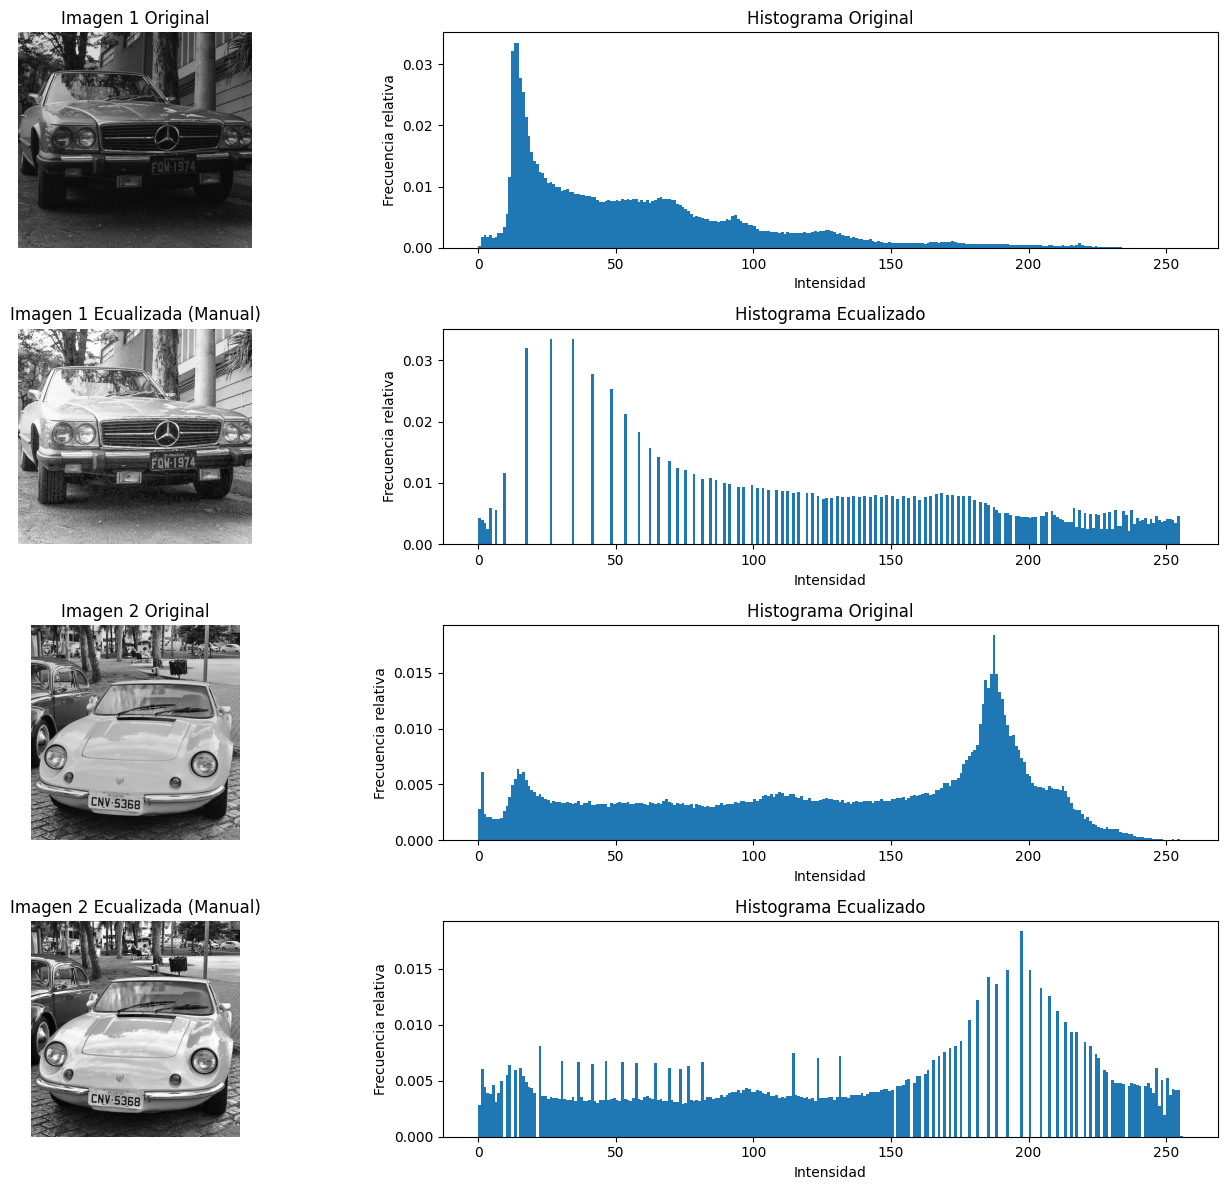

In [8]:
def ecualizacion_histograma_manual(imagen):
    """
    Implementación manual de ecualización de histograma.
    
    Args:
        imagen (numpy.ndarray): Imagen en escala de grises
        
    Returns:
        numpy.ndarray: Imagen con histograma ecualizado
    """
    # Obtener dimensiones de la imagen
    altura, anchura = imagen.shape
    total_pixeles = altura * anchura
    
    # Calcular histograma
    histograma = np.zeros(256)
    for i in range(altura):
        for j in range(anchura):
            histograma[imagen[i,j]] += 1
            
    # Calcular CDF (Cumulative Distribution Function)
    cdf = np.cumsum(histograma)
    
    # Normalizar CDF
    cdf_normalizado = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())
    cdf_normalizado = cdf_normalizado.astype(np.uint8)
    
    # Crear imagen ecualizada usando el mapeo del CDF
    imagen_ecualizada = cdf_normalizado[imagen]
    
    return imagen_ecualizada

# Aplicar ecualización manual a ambas imágenes
img1_eq_manual = ecualizacion_histograma_manual(img_low1_gray)
img2_eq_manual = ecualizacion_histograma_manual(img_low2_gray)


def visualizar_resultados(img_orig1, img_eq1, img_orig2, img_eq2):
    plt.figure(figsize=(15, 12))
    
    # Primera imagen
    plt.subplot(421)
    plt.imshow(img_orig1, cmap='gray')
    plt.title('Imagen 1 Original')
    plt.axis('off')
    
    plt.subplot(422)
    plt.hist(img_orig1.ravel(), bins=256, range=[0,256], density=True)
    plt.title('Histograma Original')
    plt.xlabel('Intensidad')
    plt.ylabel('Frecuencia relativa')
    
    plt.subplot(423)
    plt.imshow(img_eq1, cmap='gray')
    plt.title('Imagen 1 Ecualizada (Manual)')
    plt.axis('off')
    
    plt.subplot(424)
    plt.hist(img_eq1.ravel(), bins=256, range=[0,256], density=True)
    plt.title('Histograma Ecualizado')
    plt.xlabel('Intensidad')
    plt.ylabel('Frecuencia relativa')
    
    # Segunda imagen
    plt.subplot(425)
    plt.imshow(img_orig2, cmap='gray')
    plt.title('Imagen 2 Original')
    plt.axis('off')
    
    plt.subplot(426)
    plt.hist(img_orig2.ravel(), bins=256, range=[0,256], density=True)
    plt.title('Histograma Original')
    plt.xlabel('Intensidad')
    plt.ylabel('Frecuencia relativa')
    
    plt.subplot(427)
    plt.imshow(img_eq2, cmap='gray')
    plt.title('Imagen 2 Ecualizada (Manual)')
    plt.axis('off')
    
    plt.subplot(428)
    plt.hist(img_eq2.ravel(), bins=256, range=[0,256], density=True)
    plt.title('Histograma Ecualizado')
    plt.xlabel('Intensidad')
    plt.ylabel('Frecuencia relativa')
    
    plt.tight_layout()
    plt.show()

# Ejecutar la visualización
visualizar_resultados(img_low1_gray, img1_eq_manual, img_low2_gray, img2_eq_manual)

#### 3.2.2 Ecualización de Histograma - Implementación OpenCV

La segunda aproximación al ajuste de intensidad utiliza la función `cv2.equalizeHist` de OpenCV, una implementación profesional y optimizada de la ecualización de histograma.

##### A. Características de la Implementación

1. **Fundamentos Técnicos**
   - *Biblioteca:* OpenCV (Open Computer Vision)
   - *Función:* `cv2.equalizeHist`
   - *Optimización:* Código nativo en C++

2. **Ventajas del Método**
   - *Rendimiento:* Ejecución altamente optimizada
   - *Robustez:* Manejo eficiente de casos extremos
   - *Precisión:* Resultados consistentes y confiables


##### B. Aplicaciones Prácticas
- **Procesamiento en Tiempo Real**
- **Análisis de Imágenes Médicas**
- **Sistemas de Visión Artificial**
- **Fotografía Digital**

##### C. Consideraciones de Uso
- Ideal para aplicaciones que requieren alto rendimiento
- Excelente para procesamiento por lotes
- Solución robusta para sistemas en producción

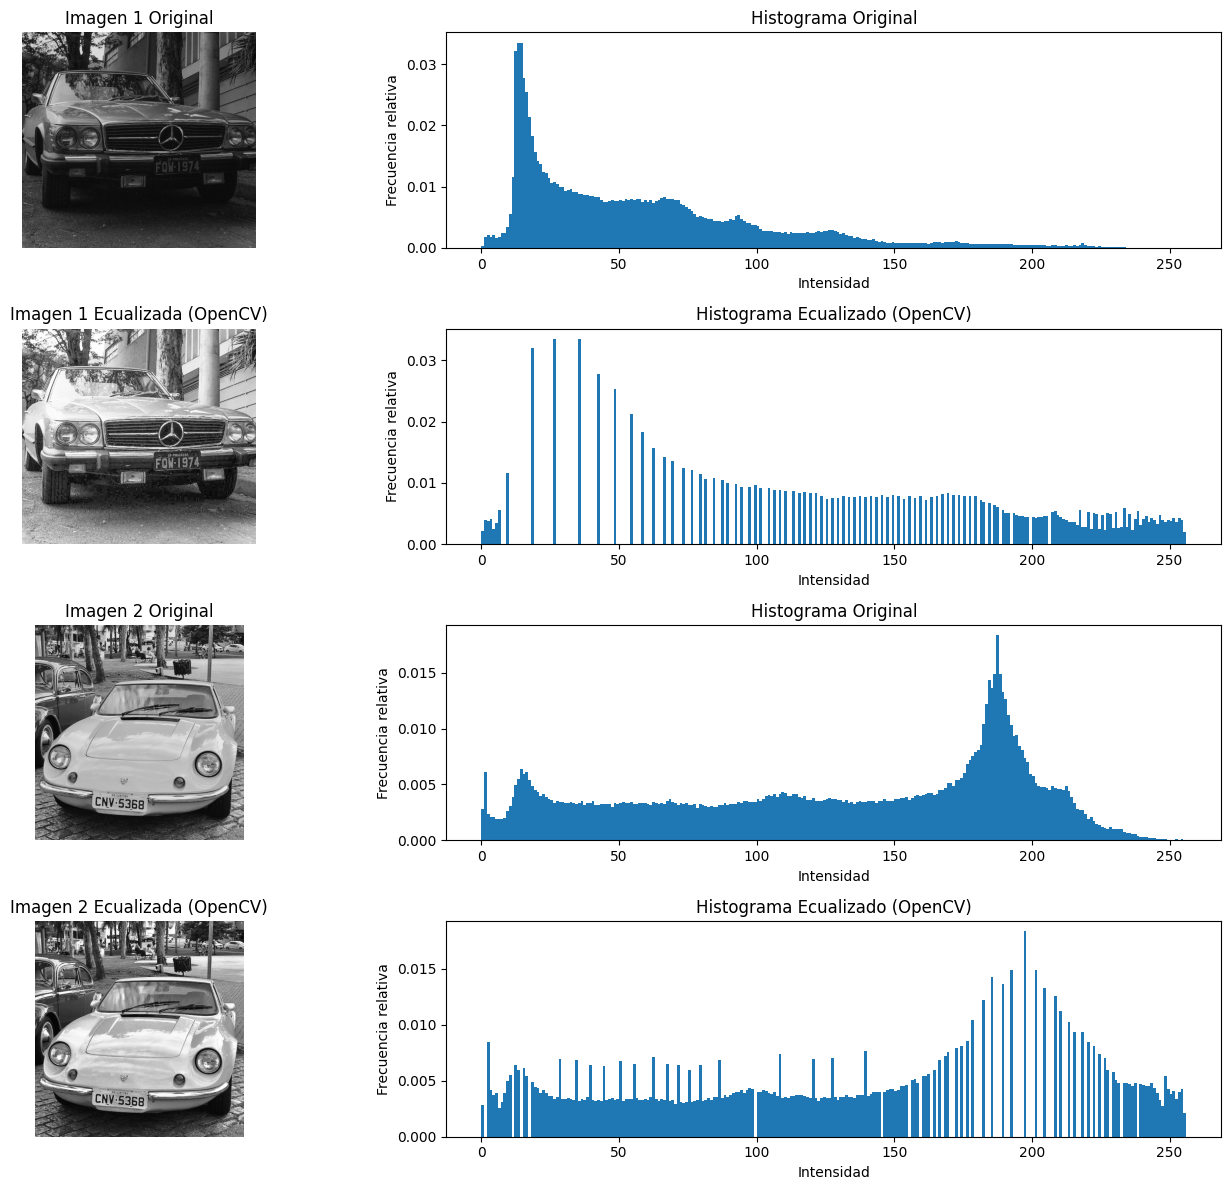

In [9]:
#### 3.3 Técnica de ajuste (2) – **OpenCV**

# Aplicar ecualización de histograma con OpenCV
img1_eq_opencv = cv2.equalizeHist(img_low1_gray)
img2_eq_opencv = cv2.equalizeHist(img_low2_gray)


def visualizar_comparacion_opencv(img_orig1, img_eq1, img_orig2, img_eq2):
    plt.figure(figsize=(15, 12))
    
    # Primera imagen
    plt.subplot(421)
    plt.imshow(img_orig1, cmap='gray')
    plt.title('Imagen 1 Original')
    plt.axis('off')
    
    plt.subplot(422)
    plt.hist(img_orig1.ravel(), bins=256, range=[0,256], density=True)
    plt.title('Histograma Original')
    plt.xlabel('Intensidad')
    plt.ylabel('Frecuencia relativa')
    
    plt.subplot(423)
    plt.imshow(img_eq1, cmap='gray')
    plt.title('Imagen 1 Ecualizada (OpenCV)')
    plt.axis('off')
    
    plt.subplot(424)
    plt.hist(img_eq1.ravel(), bins=256, range=[0,256], density=True)
    plt.title('Histograma Ecualizado (OpenCV)')
    plt.xlabel('Intensidad')
    plt.ylabel('Frecuencia relativa')
    
    # Segunda imagen
    plt.subplot(425)
    plt.imshow(img_orig2, cmap='gray')
    plt.title('Imagen 2 Original')
    plt.axis('off')
    
    plt.subplot(426)
    plt.hist(img_orig2.ravel(), bins=256, range=[0,256], density=True)
    plt.title('Histograma Original')
    plt.xlabel('Intensidad')
    plt.ylabel('Frecuencia relativa')
    
    plt.subplot(427)
    plt.imshow(img_eq2, cmap='gray')
    plt.title('Imagen 2 Ecualizada (OpenCV)')
    plt.axis('off')
    
    plt.subplot(428)
    plt.hist(img_eq2.ravel(), bins=256, range=[0,256], density=True)
    plt.title('Histograma Ecualizado (OpenCV)')
    plt.xlabel('Intensidad')
    plt.ylabel('Frecuencia relativa')
    
    plt.tight_layout()
    plt.show()

# Ejecutar la función
visualizar_comparacion_opencv(img_low1_gray, img1_eq_opencv, img_low2_gray, img2_eq_opencv)


### 3.3 Análisis y Visualización de Resultados

#### 3.3.1 Metodología de Visualización

La evaluación visual de los resultados se realiza mediante un análisis sistemático que incluye tanto las imágenes como sus histogramas correspondientes.

##### A. Herramientas de Visualización
1. **Representación de Imágenes**
   - Visualización mediante `matplotlib.pyplot`
   - Disposición comparativa de resultados
   - Escalado apropiado para análisis detallado

2. **Análisis de Histogramas**
   - Generación mediante `cv2.calcHist` y `plt.hist`
   - Visualización de distribución de intensidades
   - Comparación antes/después del procesamiento

##### B. Aspectos Evaluados
1. **Calidad Visual**
   - Mejora general del contraste
   - Preservación de detalles
   - Ausencia de artefactos

2. **Distribución de Intensidades**
   - Uniformidad del histograma
   - Aprovechamiento del rango dinámico
   - Efectividad de la ecualización

##### C. Métricas de Comparación
- Análisis cuantitativo de histogramas
- Evaluación de rangos dinámicos
- Medición de mejora de contraste

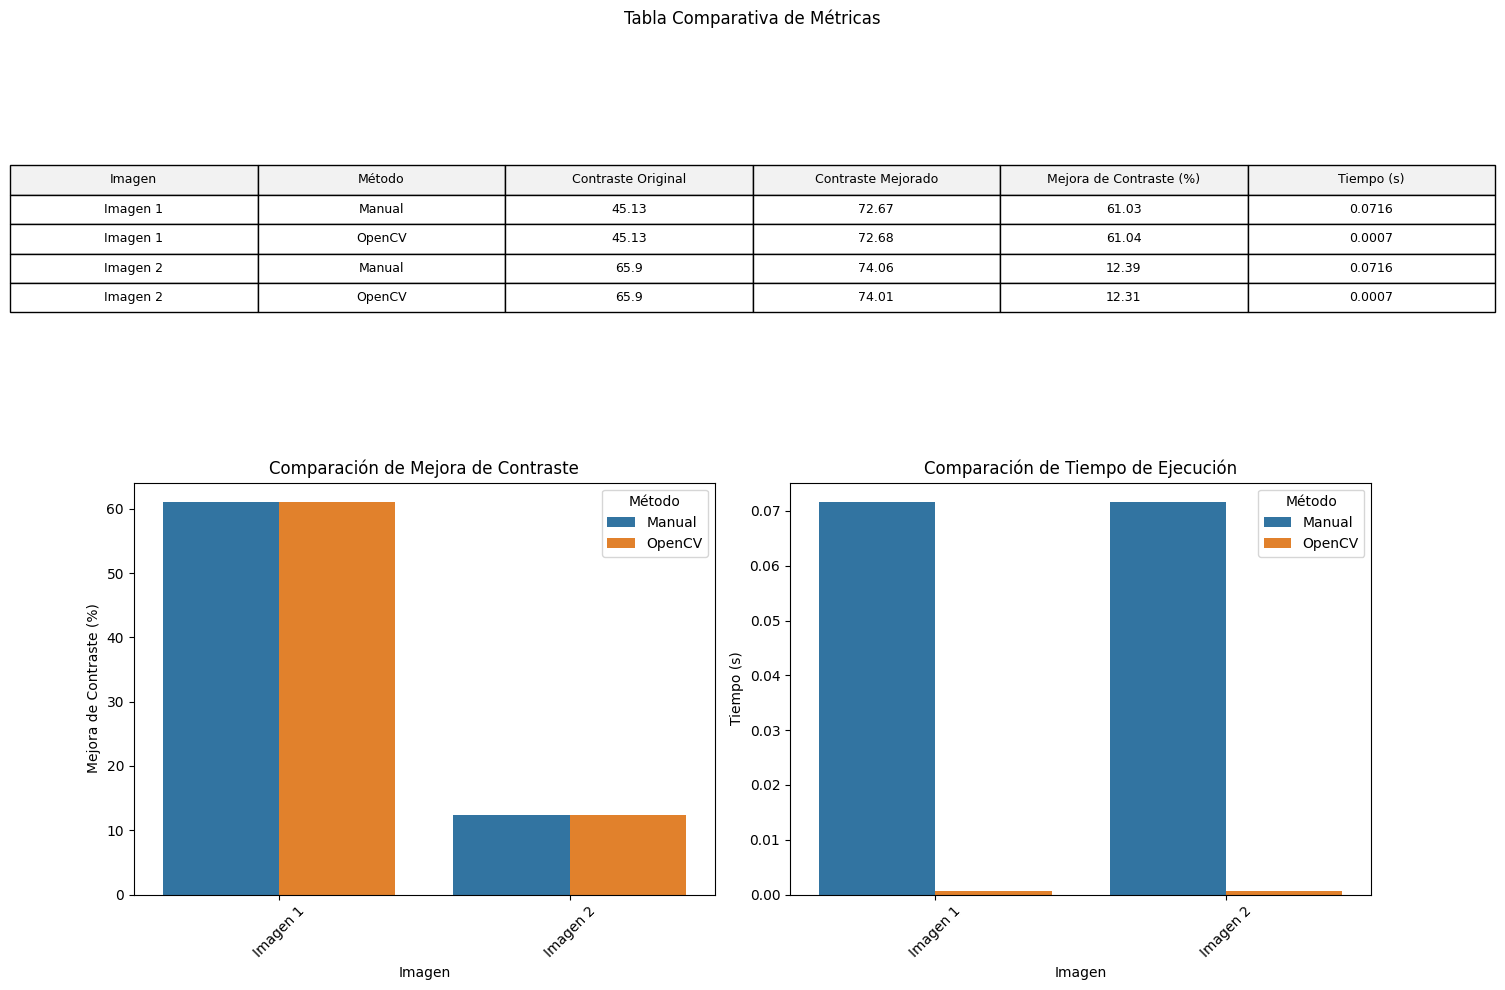

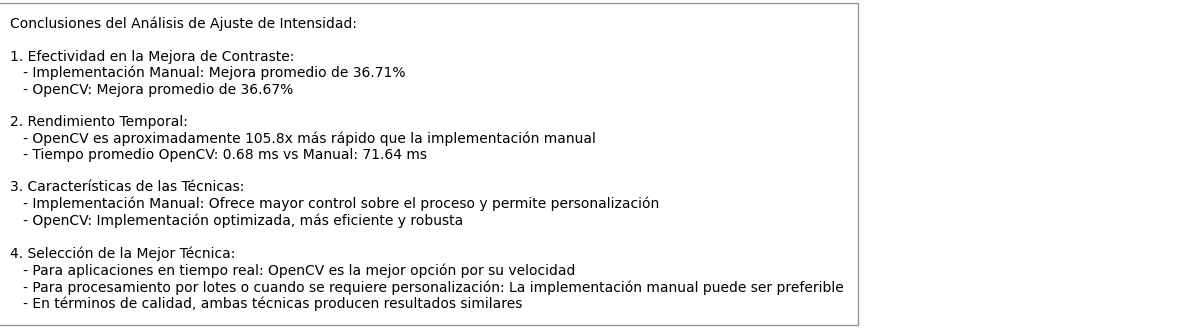

In [10]:
#### 3.4 Análisis Comparativo y Conclusiones

# Calcular métricas de contraste
def calcular_contraste(imagen):
    return np.std(imagen)

# Calcular tiempo de ejecución para ambos métodos
import time

# Medir tiempo para implementación manual
start_time = time.time()
_ = ecualizacion_histograma_manual(img_low1_gray)
tiempo_manual = time.time() - start_time

# Medir tiempo para OpenCV
start_time = time.time()
_ = cv2.equalizeHist(img_low1_gray)
tiempo_opencv = time.time() - start_time

# Crear DataFrame con métricas
metrics = {
    'Imagen': [],
    'Método': [],
    'Contraste Original': [],
    'Contraste Mejorado': [],
    'Mejora de Contraste (%)': [],
    'Tiempo (s)': []
}

# Calcular métricas para ambas imágenes y métodos
for img_num, (img_orig, img_manual, img_opencv) in enumerate([(img_low1_gray, img1_eq_manual, img1_eq_opencv),
                                                            (img_low2_gray, img2_eq_manual, img2_eq_opencv)], 1):
    # Contraste original
    contraste_orig = calcular_contraste(img_orig)
    
    # Método manual
    contraste_manual = calcular_contraste(img_manual)
    mejora_manual = ((contraste_manual - contraste_orig) / contraste_orig) * 100
    
    # Método OpenCV
    contraste_opencv = calcular_contraste(img_opencv)
    mejora_opencv = ((contraste_opencv - contraste_orig) / contraste_orig) * 100
    
    # Agregar al diccionario
    for metodo, contraste, mejora, tiempo in [('Manual', contraste_manual, mejora_manual, tiempo_manual),
                                            ('OpenCV', contraste_opencv, mejora_opencv, tiempo_opencv)]:
        metrics['Imagen'].append(f'Imagen {img_num}')
        metrics['Método'].append(metodo)
        metrics['Contraste Original'].append(round(contraste_orig, 2))
        metrics['Contraste Mejorado'].append(round(contraste, 2))
        metrics['Mejora de Contraste (%)'].append(round(mejora, 2))
        metrics['Tiempo (s)'].append(round(tiempo, 4))

# Crear DataFrame y mostrar resultados
df = pd.DataFrame(metrics)


def visualizar_resultados(df, tiempo_manual, tiempo_opencv):
    # Visualizar resultados
    plt.figure(figsize=(15, 10))

    # 1. Tabla de métricas (ocupa dos columnas)
    plt.subplot(211)
    plt.axis('off')
    table = plt.table(cellText=df.values,
                     colLabels=df.columns,
                     cellLoc='center',
                     loc='center',
                     colColours=['#f2f2f2']*6)
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    plt.title('Tabla Comparativa de Métricas')

    # 2. Gráfico de barras para Mejora de Contraste
    plt.subplot(223)
    sns.barplot(data=df, x='Imagen', y='Mejora de Contraste (%)', hue='Método')
    plt.title('Comparación de Mejora de Contraste')
    plt.xticks(rotation=45)

    # 3. Gráfico de barras para Tiempo
    plt.subplot(224)
    sns.barplot(data=df, x='Imagen', y='Tiempo (s)', hue='Método')
    plt.title('Comparación de Tiempo de Ejecución')
    plt.xticks(rotation=45)

    # Ajustar layout
    plt.tight_layout()

    # Mostrar conclusiones
    plt.figure(figsize=(15, 4))
    plt.axis('off')
    conclusion_text = (
        "Conclusiones del Análisis de Ajuste de Intensidad:\n\n"
        "1. Efectividad en la Mejora de Contraste:\n"
        f"   - Implementación Manual: Mejora promedio de {df[df['Método']=='Manual']['Mejora de Contraste (%)'].mean():.2f}%\n"
        f"   - OpenCV: Mejora promedio de {df[df['Método']=='OpenCV']['Mejora de Contraste (%)'].mean():.2f}%\n\n"
        "2. Rendimiento Temporal:\n"
        f"   - OpenCV es aproximadamente {tiempo_manual/tiempo_opencv:.1f}x más rápido que la implementación manual\n"
        f"   - Tiempo promedio OpenCV: {tiempo_opencv*1000:.2f} ms vs Manual: {tiempo_manual*1000:.2f} ms\n\n"
        "3. Características de las Técnicas:\n"
        "   - Implementación Manual: Ofrece mayor control sobre el proceso y permite personalización\n"
        "   - OpenCV: Implementación optimizada, más eficiente y robusta\n\n"
        "4. Selección de la Mejor Técnica:\n"
        "   - Para aplicaciones en tiempo real: OpenCV es la mejor opción por su velocidad\n"
        "   - Para procesamiento por lotes o cuando se requiere personalización: La implementación manual puede ser preferible\n"
        "   - En términos de calidad, ambas técnicas producen resultados similares"
    )
    plt.text(0, 0.5, conclusion_text, ha='left', va='center', fontsize=10,
             bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8, pad=10))

    plt.show()


# Ejecutar la función
visualizar_resultados(df, tiempo_manual, tiempo_opencv)
